In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import nuSQUIDSpy as nsq
import pickle

plt.style.use('./paper.mplstyle')

In [2]:
units = nsq.Const()
gr = nsq.GlashowResonanceCrossSection()
dis = nsq.NeutrinoDISCrossSectionsFromTables()
tds = nsq.TauDecaySpectra()

In [3]:
File = open('taus_rock_ALLM97_lpm_vcut1e-3_MMC_Ordered_weighted.pickle','r')
tau_loss_array = pickle.load(File)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def SampleFinalTauParams(e_in):
    if (e_in < 1e6):
        return(e_in, 1e-4)
    else:
        eins = np.logspace(6,16,500)
        e_in = find_nearest(eins, e_in)
        choices = tau_loss_array[e_in]['choices']
        weights = tau_loss_array[e_in]['weights']
        choice_index = np.arange(0, len(choices))

        index = np.random.choice(choice_index, p=weights)
        (e_final, distance) = choices[index]

        return(10**e_final, 10**distance)

In [468]:
def TotalNeutrinoCrossSection(enu, 
                              flavor = nsq.NeutrinoCrossSections_NeutrinoFlavor.electron,
                              neutype = nsq.NeutrinoCrossSections_NeutrinoType.neutrino,
                              interaction = nsq.NeutrinoCrossSections_Current.NC):
    return dis.TotalCrossSection(enu,flavor,neutype,interaction)*(units.cm)**2

def DifferentialOutGoingLeptonDistribution(enu_in,enu_out,
                                       flavor = nsq.NeutrinoCrossSections_NeutrinoFlavor.tau,
                                       neutype = nsq.NeutrinoCrossSections_NeutrinoType.neutrino,
                                       interaction = nsq.NeutrinoCrossSections_Current.NC
                                    ):
    diff = dis.SingleDifferentialCrossSection(enu_in,enu_out,flavor,neutype,interaction)
    return diff

In [469]:
Etau = 100.
zz = np.linspace(0.0,1.0,500)[1:-1]
dNTaudz = lambda z: tds.TauDecayToAll(Etau, Etau*z)
TauDecayWeights = np.array(map(dNTaudz,zz))
TauDecayWeights = TauDecayWeights/np.sum(TauDecayWeights)

yy = np.linspace(0.0,1.0,300)[1:-1]

proton_mass = 0.938*units.GeV

In [470]:
class CasinoEvent(object):
    def __init__(self, particle_id, energy, position):
        ## need to add tree in an efficient way

        self.particle_id = particle_id
        self.energy = energy
        self.position = position
        self.SetParticleProperties()
        self.history = ["Event created as " + particle_id]
        
    def SetParticleProperties(self):
        if self.particle_id == "tau_neutrino":
            self.mass = 0.0
            self.lifetime = np.inf
        if self.particle_id == "tau":
            self.mass = 1.7*units.GeV
            self.lifetime = 1.*units.sec
            
    def GetParticleId(self):
        return self.particle_id
    
    def GetLifetime(self):
        return self.lifetime
    
    def GetMass(self):
        return self.mass
    
    def GetBoostFactor(self):
        if self.mass > 0.:
            return self.energy/self.mass
        else:
            return np.inf
            
    def GetDecayProbability(self,dL):
        boost_factor = self.GetBoostFactor()
        return dL/(boost_factor*self.lifetime)
    
    def GetInteractionLength(self,density,interaction):
        if self.particle_id == "tau_neutrino":
            # this should be actually divided by average of proton and neutron mass
            #print TotalNeutrinoCrossSection(self.energy, interaction = interaction), self.energy, interaction
            return proton_mass/(TotalNeutrinoCrossSection(self.energy, interaction = interaction)*density)
        if self.particle_id == "tau":
            # here we need the total tau cross section
            #return TotalNeutrinoCrossSection(self.energy)*density/(proton_mass)
            return 0.01*units.cm
    
    def GetInteractionProbability(self,dL,density,interaction):
        return 1.-np.exp(-dL/self.GetInteractionLength(density,interaction))
    
    def DecayParticle(self):
        if self.particle_id == "tau_neutrino":
            self.history.append("Neutrino decayed???")
            return
        if self.particle_id == "tau":
            self.energy = self.energy*np.random.choice(zz, p=TauDecayWeights)
            self.particle_id = "tau_neutrino"
            self.SetParticleProperties()
            self.history.append("Tau decayed")
            return
            
    def InteractParticle(self, interaction):
        if self.particle_id == "tau_neutrino":

            dNdEle = lambda y: DifferentialOutGoingLeptonDistribution(self.energy,self.energy*y,
                                                                      interaction = interaction)
            NeutrinoInteractionWeights = map(dNdEle,yy)
            NeutrinoInteractionWeights = NeutrinoInteractionWeights/np.sum(NeutrinoInteractionWeights)
            self.energy = self.energy*np.random.choice(yy, p=NeutrinoInteractionWeights)
            
            if interaction == nsq.NeutrinoCrossSections_Current.CC:
                self.particle_id = "tau"
                self.SetParticleProperties()
            elif interaction == nsq.NeutrinoCrossSections_Current.NC:
                self.particle_id = "tau_neutrino"
                self.SetParticleProperties()
            
            self.history.append("Neutrino Interacted")
            return
        if self.particle_id == "tau":
            Efin, Ladv = SampleFinalTauParams(self.energy/units.GeV)
            self.energy = Efin*units.GeV
            self.position += Ladv*units.km
            self.history.append("Tau Interacted")
            self.DecayParticle()
            return
        
    def PrintParticleProperties(self):
        print "id", self.particle_id, \
              "energy ", self.energy/units.GeV, " GeV", \
              "position ", self.position/units.km, " km"

In [471]:
def RollDice(initial_neutrino_energy,
             TotalDistance = 12000.*units.km,
             ProposedDistanceStep = 100.*units.km,
             density = 1.*units.gr/(units.cm**3)):
    FirstEvent = CasinoEvent("tau_neutrino",initial_neutrino_energy,0.0)
    EventCollection = [FirstEvent]

    while(not np.any(map(lambda e: (e.position > TotalDistance) or (e.energy < e.GetMass()), EventCollection))):
        for event in EventCollection:
            p = np.random.random_sample()
            if event.GetDecayProbability(ProposedDistanceStep) > p:
                event.DecayParticle()
                continue

            p = np.random.random_sample()
            p_int = event.GetInteractionProbability(ProposedDistanceStep,density,
                                                    interaction = nsq.NeutrinoCrossSections_Current.CC)
            if p_int > 1:
                print "pick smaller step"
            if p_int > p:
                event.InteractParticle(nsq.NeutrinoCrossSections_Current.CC)
                continue
                
            p = np.random.random_sample()
            p_int = event.GetInteractionProbability(ProposedDistanceStep,density, 
                                                    interaction = nsq.NeutrinoCrossSections_Current.NC)
            if p_int > 1:
                print "pick smaller step"
            if p_int > p:
                event.InteractParticle(nsq.NeutrinoCrossSections_Current.NC)
                continue
                
        # move everything forward
        for event in EventCollection:
            event.position += ProposedDistanceStep
    return EventCollection

In [472]:
eini = 1.e9*units.GeV
HardCasinoGame = np.array([RollDice(eini)[0] for i in xrange(1000)])

eini = 2.e6*units.GeV
EasyCasinoGame = np.array([RollDice(eini)[0] for i in xrange(1000)])

Text(0.5,0,u'$\\log(E_\\nu / {\\rm GeV})$')

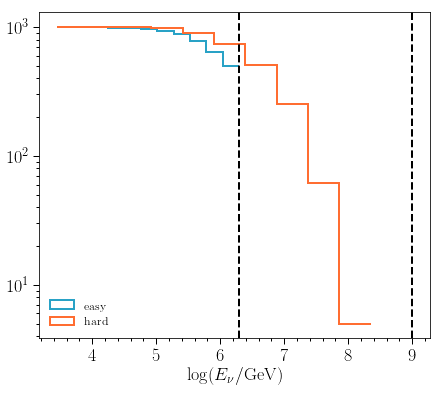

In [474]:
plt.figure(figsize=(7,6))
plt.axvline(np.log10(1.e9), ls = "dashed", color = "k")
plt.hist(map(lambda x : np.log10(x.energy/units.GeV), EasyCasinoGame),
         label = "easy", histtype="step", cumulative = -1)
plt.axvline(np.log10(2.e6), ls = "dashed", color = "k")
plt.hist(map(lambda x : np.log10(x.energy/units.GeV), HardCasinoGame),
         label = "hard", histtype="step", cumulative = -1)
plt.semilogy()
plt.legend(loc = "best")
plt.xlabel(r"$\log(E_\nu / {\rm GeV})$")

In [475]:
EasyCasinoGame[0].history

['Event created as tau_neutrino']